# Autoencoders

# I. Vanilla Autoencoder

В данном блокноте мы создадим свой автоэнкодер, обучим его, посмотрим на то, как он способен кодировать и декодировать изображения лиц. Также на основе этого автоэнкодера мы сгенерируем новые лица, научимся из грустных людей на фотографиях делать весёлых, менять пол человека. И в конце посмотрим на то, какие архитектуры автоэнкодеров могут быть «хорошими» и «плохими».

## Содержание

- [Подготовка окружения](#environment)

- [Подготовка данных](#data)
    
- [Архитектура модели](#architecture_ae)

- [Обучение](#train_ae)

    - [Функции для обучения AE](#train_ae_func)

    - [Обучение AE](#ae_train)

- [Reconstruction AE](#reconstruction_ae)

- [Sampling](#sampling_ae)

- [Time to make fun!](#make_fun)

- [💃🕺](#gender)

- [Что такое хорошо и что такое плохо?](#good_or_bad)

    - [VGG-16](#vgg16)

    - [SegAutoencoder](#seg_ae)
    

<a id='environment'></a>
## Подготовка окружения
Импортируем необходимые библиотеки

In [ ]:
import warnings
from IPython.display import clear_output
from tqdm import tqdm
from time import time
import seaborn as sns
import os
import pickle
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchsummary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import skimage.io
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patheffects as path_effects
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.2)


warnings.filterwarnings(action='ignore', category=DeprecationWarning)

[Reproducibility (Pytorch):](https://pytorch.org/docs/stable/notes/randomness.html)

In [ ]:
def set_seed(seed):
    """Установить зерно генераторов случайных чисел"""

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def seed_worker(worker_id):
    """Воспроизводимость DataLoader'a (см. ссылку выше)"""

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


set_seed(42)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
!nvidia-smi

Thu Jan  6 11:55:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Далее будем сохранять лучшие модели

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

DATA_DIR = '/content/gdrive/MyDrive/autoencoders/weights'

Mounted at /content/gdrive/


<a id='data'></a>
## Подготовка данных

In [ ]:
def fetch_dataset(attrs_name="lfw_attributes.txt",
                  images_name="lfw-deepfunneled",
                  dx=80, dy=80,
                  dimx=64, dimy=64
                  ):

    # Скачать, если не существует
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system(
            "wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system(
            "wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    # Считываем атрибуты
    df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(
        df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])

    # Считываем фотографии
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append(
                    {'person': person_id, 'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)

    # Mass-merge
    df = pd.merge(df_attrs, photo_ids, on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    # print(df.shape)
    # Предобработка изображений
    all_photos = df['photo_path'].apply(skimage.io.imread)\
        .apply(lambda img: img[dy:-dy, dx:-dx])\
        .apply(lambda img: resize(img, [dimx, dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [ ]:
# Следующая строка возвращает два набора данных: изображения, используемые
# для обучения автоэнкодера, и атрибуты
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


Посмотрим на содержимое датафрейма с атрибутами изображений

In [ ]:
attrs.head()

Male     Asian  ... Wearing Necktie Wearing Necklace
0   1.56835  -1.88904  ...        0.694007        -0.826609
1  0.169851 -0.982408  ...         0.66676        -0.496559
2  0.997749  -1.36419  ...        0.144262        -0.841231
3   1.12272   -1.9978  ...        0.475941        -0.447025
4   1.07821   -2.0081  ...       -0.760774        -0.410152

[5 rows x 73 columns]


Разобьем выборку картинок на обучение и валидацию, создадим даталоэдеры, выведем несколько картинок в output, чтобы посмотреть, как они выглядят.

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9,
                                                                    shuffle=True,
                                                                    random_state=42)

In [ ]:
batch_size = 64

# Используем rollaxis, чтобы привести батч к (BatchSize x C x H x W)
train_loader = DataLoader(np.rollaxis(train_photos, 3, 1), batch_size,
                          shuffle=True, worker_init_fn=seed_worker)
val_loader = DataLoader(np.rollaxis(val_photos, 3, 1), batch_size)

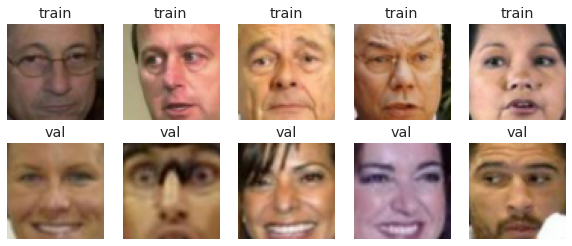

In [ ]:
x_train = next(iter(train_loader)).numpy()
x_val = next(iter(val_loader)).numpy()

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.rollaxis(x_train[i], 0, 3))
    plt.axis("off")
    plt.title('train')

    plt.subplot(2, 5, i+6)
    plt.imshow(np.rollaxis(x_val[i], 0, 3))
    plt.axis("off")
    plt.title('val')

plt.show()

<a id='architecture_ae'></a>
## Архитектура модели
В этом разделе мы напишем и обучим обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder"  height="300">
 

Архитектуру для нашего автоэнкодера возьмем произвольную. Энкодер и декодер части будут состоять из convolution (Conv, ReLU и BatchNorm слои) и fully connected частей.

In [ ]:
dim_code = 128  # Размерность латентного пространства


class Autoencoder(nn.Module):
    """Autoencoder"""

    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # Feature Extractor
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=5, stride=2, dilation=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=5, stride=2, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Flatten(),

            # FC
            nn.Linear(in_features=256*4*4, out_features=256*4),
            nn.ReLU(),
            nn.Linear(in_features=256*4, out_features=dim_code)
        )

        self.decoder = nn.Sequential(
            # FC
            nn.Linear(in_features=dim_code, out_features=256*4),
            nn.ReLU(),
            nn.Linear(in_features=256*4, out_features=256*4*4),

            nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),

            # Feature Extractor
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=5, stride=2, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=5,
                               stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """Forward проход автоэнкодера
        latent_code - латентное представление картинки
        reconstruction - полученная реконструкция изображения
        """

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

Определим функцию потерь, модель, оптимизатор и шедулер. Для начала в качестве лосса будем использовать *MSE*.

In [ ]:
criterion = F.mse_loss

autoencoder = Autoencoder().to(DEVICE)

optimizer = optim.AdamW(params=autoencoder.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
# Архитектура нашего автоэнкодера
torchsummary.summary(autoencoder, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 30, 30]         102,464
       BatchNorm2d-5           [-1, 64, 30, 30]             128
              ReLU-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 30, 30]          73,856
       BatchNorm2d-8          [-1, 128, 30, 30]             256
              ReLU-9          [-1, 128, 30, 30]               0
        MaxPool2d-10          [-1, 128, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         295,168
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             ReLU-13          [-1, 256, 15, 15]               0
           Conv2d-14            [-1, 25

<a id='train_ae'></a>
## Обучение
Напишем функции для обучения автоэнкодера. Реализуем возможность в процессе обучения смотреть, как автоэнкодер реконструирует изображения на данной эпохе. Также в процессе обучения будем выводить графики для лоссов на обучающих и валидационных данных.

<a id='train_ae_func'></a>
### Функции для обучения AE

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Обучить сеть на одной эпохе, вернуть лосс на train'е"""

    model.train()
    presently_loss = 0.  # Суммарный лосс train'а на данной эпохе
    number_images = 0   # Количество изображений на данной эпохе

    for inputs in train_loader:
        inputs = inputs.to(DEVICE)

        reconstruct, latent = model(inputs)
        loss = criterion(reconstruct, inputs)

        loss.backward()
        optimizer.step()

        # Размер батча на данной иттерации.
        # Используем не заданное в начале значение batch size, т.к. размер
        # последнего батча может отличаться
        presently_batch_size = inputs.shape[0]
        number_images += presently_batch_size
        presently_loss += loss.item() * presently_batch_size

        optimizer.zero_grad()

    train_loss = presently_loss / number_images

    return train_loss

In [ ]:
def eval_epoch(model, val_loader, criterion):
    """Сделать предсказание на одной эпохе, вернуть лосс на валидации"""

    model.eval()
    presently_loss = 0.  # Суммарный валидационный лосс на данной эпохе
    number_images = 0   # Количество изображений на данной эпохе

    with torch.no_grad():
        for inputs in val_loader:
            inputs = inputs.to(DEVICE)

            reconstruct, latent = model(inputs)
            loss = criterion(reconstruct, inputs)

            presently_batch_size = inputs.shape[0]
            number_images += presently_batch_size
            presently_loss += loss.item() * presently_batch_size

    val_loss = presently_loss / number_images

    return val_loss

In [ ]:
def plot_reconstr_loss(x_val, x_reconstr, train_losses, val_losses):
    """Вывести исходные и восстановленные изображения,
    построить графики для лоссов в процессе обучения
    """

    plt.figure(figsize=(12, 8))

    for i in range(6):
        plt.subplot(3, 6, i+1)
        plt.axis("off")
        plt.imshow(np.rollaxis(x_val[i], 0, 3))
        plt.title('original')

        plt.subplot(3, 6, i+7)
        plt.axis("off")
        plt.imshow(np.rollaxis(x_reconstr[i], 0, 3))
        plt.title('reconstruct')

    plt.subplot(3, 1, 3)
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs,
                criterion, optimizer, scheduler):
    """Полный цикл обучения модели"""

    X_val = next(iter(val_loader))

    best_loss = 9999999

    since = time()

    dict_losses = {
        'train_loss': [],
        'val_loss': []
    }

    log_template = "\nEpoch {ep:03d}  train_loss: {t_loss:0.4f} \
     val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            set_seed(42 + 3 * epoch)

            # Train и val лоссы на текущей эпохе
            t_loss = train_epoch(model, train_loader, criterion, optimizer)
            v_loss = eval_epoch(model, val_loader, criterion)

            scheduler.step()

            # Сохраняем лосс на данной эпохе для графиков
            dict_losses['train_loss'].append(t_loss)
            dict_losses['val_loss'].append(v_loss)

            # Сохранить лучшую модель
            if best_loss > v_loss:
                best_loss = v_loss
                best_t_loss = t_loss
                torch.save(model.state_dict(),
                           os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
                best_epoch = epoch + 1
                best_time = time() - since

            # Сохранить текущую модель
            torch.save(model.state_dict(),
                       os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))

            # Промежуточный результат
            model.eval()  # testing mode
            with torch.no_grad():
                x_reconstr, latent = model(X_val.to(DEVICE))
                x_reconstr = x_reconstr.detach().cpu().numpy()

            # Visualize tools
            clear_output(wait=True)

            pbar_outer.update(1)
            tqdm.write(log_template.format(
                ep=epoch+1,
                t_loss=t_loss,
                v_loss=v_loss
            )
            )

            plot_reconstr_loss(
                X_val.numpy(),
                x_reconstr,
                dict_losses['train_loss'],
                dict_losses['val_loss']
            )

    print(
        f'Training is done! Best epoch {best_epoch}, best time {best_time}, best val loss {best_loss}, best train loss {best_t_loss}')

    # Загрузить веса лучшей модели
    model.load_state_dict(torch.load(
        os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))

    return model

<a id='ae_train'></a>
### Обучение AE
Обучим наш автоэнкодер

epoch: 100%|██████████| 50/50 [2:38:38<00:00, 188.65s/it]


Epoch 050  train_loss: 0.0037      val_loss 0.0051


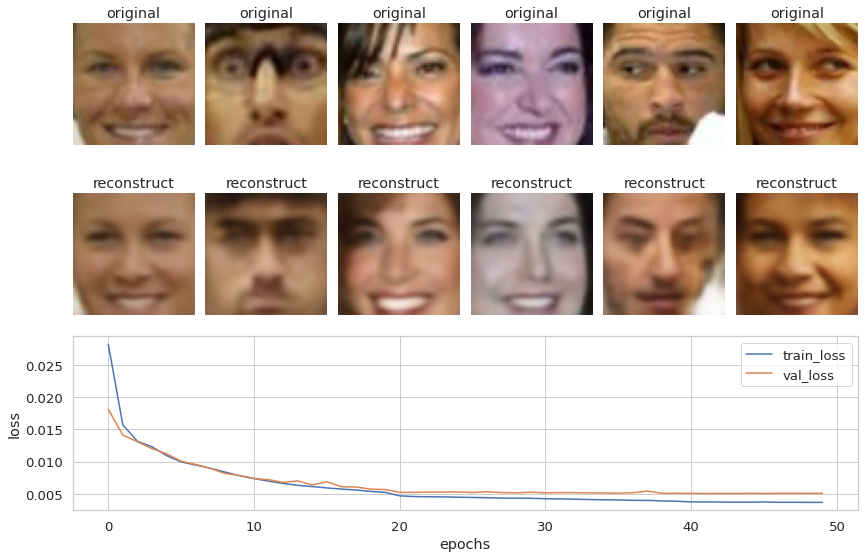

epoch: 100%|██████████| 50/50 [2:38:41<00:00, 190.43s/it]

Training is done! Best epoch 42, best time 8005.890340805054, best val loss 0.005056734511295879, best train loss 0.0037543785369819256


In [ ]:
epochs = 50
autoencoder = train_model(train_loader, val_loader, autoencoder,
                          'ae', epochs, criterion, optimizer, scheduler)

<a id='reconstruction_ae'></a>
## Reconstruction AE
Посмотрим на то, как автоэнкодер кодирует и восстанавливает лица. Для этого прогоним несколько фотографий через автоэнкодер и сравним изображения на входе и выходе AE.

In [ ]:
# Загрузим обученный автоэнкодер
autoencoder = Autoencoder().to(DEVICE)
autoencoder.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_ae.pth')))

<All keys matched successfully>

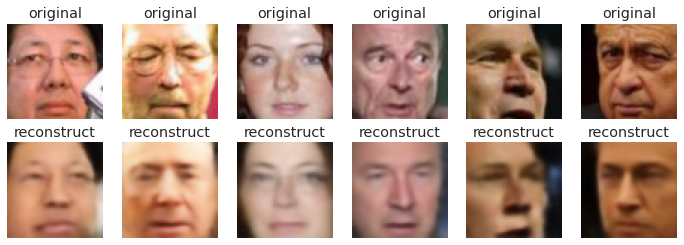

In [ ]:
x_val = next(iter(val_loader))
x_val_np = x_val.detach().numpy()

with torch.no_grad():
    x_reconstr, _ = autoencoder(x_val.to(DEVICE))
    x_reconstr = x_reconstr.cpu().numpy()

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val_np[i+7], 0, 3))
    plt.title('original')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_reconstr[i+7], 0, 3))
    plt.title('reconstruct')

plt.show()

<a id='sampling_ae'></a>
## Sampling

Теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем  <u>сгенерировать новые лица</u>.

Возьмем и передадим декодеру какие-нибудь сгенерированные нами в латентном пространстве векторы, например, из нормального распределения, и посмотрим на результат реконструкции декодера.

Давайте для начала сгенерируем 25 векторов из нормального распределения в $ℝ^{dim}$ со средним 0 и дисперсией 1. Потом отобразим эти вектора с учетом распределения векторов (точек) реальных фотографий в латентом пространстве, передадим их также на вход декодеру. Посмотрим и сравним получившиеся лица до и после отображения случайно сгенерированных векторов.

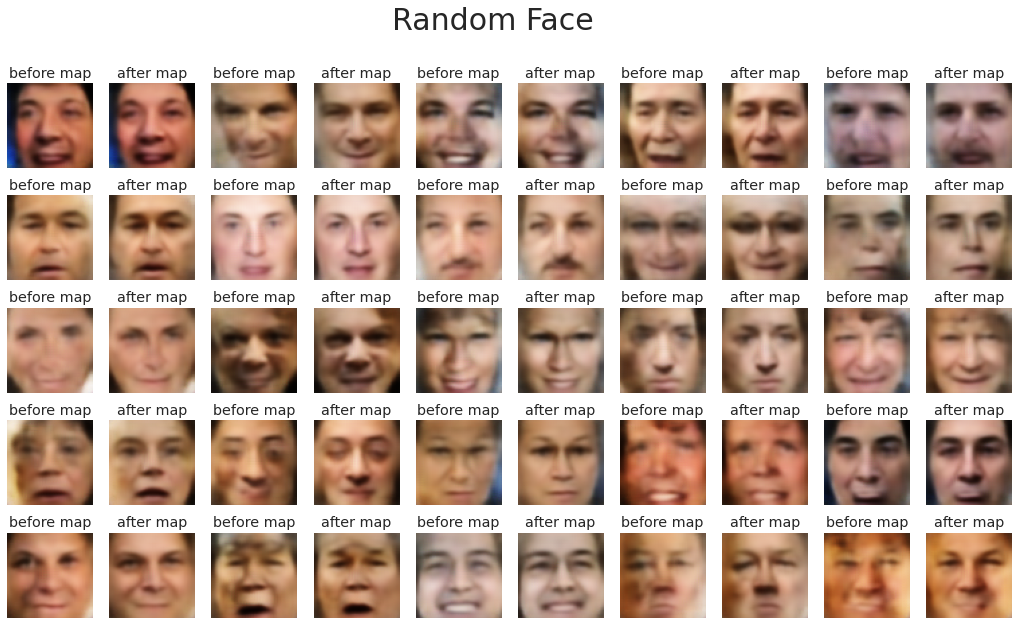

In [ ]:
# Генерируем 25 случайных векторов размера latent_space (dim_code)
z = torch.randn(25, dim_code)

# Пропускаем их через декодер и получаем случайно сгенерированные лица
with torch.no_grad():
    output_raw = autoencoder.decoder(z.to(DEVICE)).cpu().numpy()

# У нас на валидации всего 1315 фото. Переведем их в тензор
all_vall = torch.tensor(np.rollaxis(val_photos, 3, 1))

# Пропустим все эти изображения через энокдер.
# Получим 1315 вектор в латентом пространстве
with torch.no_grad():
    latent_vectors = autoencoder.encoder(all_vall.to(DEVICE)).cpu()

# Найдем среднее значение и стандартное отклонение получившихся точек в
# латентном пространстве
latent_mu = latent_vectors.mean(0).unsqueeze(0)
latent_std = latent_vectors.std(0)

# Отобразим наши случайные вектора из распределения (mu=0, std=1) в mapping_z
# с учетом полученных latent_mu и latent_std
mapping_z = latent_mu + (z * latent_std.unsqueeze(0))

# Прогоним получившиеся векторы через декодер
with torch.no_grad():
    output = autoencoder.decoder(mapping_z.to(DEVICE)).cpu().numpy()

# Покажем получившиеся изображения
plt.figure(figsize=(18, 10))
plt.suptitle('Random Face', fontsize=30)
for i in range(25):
    plt.subplot(5, 10, 2*i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(np.clip(output_raw[i], 0, 1), 0, 3))
    plt.title('before map')

    plt.subplot(5, 10, 2*i+2)
    plt.axis("off")
    plt.imshow(np.rollaxis(np.clip(output[i], 0, 1), 0, 3))
    plt.title('after map')

# Под map'ом тут понимается отображение векторов из распределения
# (mu=0,std=1) в (mu, std)

Вполне ожидаемо, что лица, которые генерируются не просто из стандартного, а из распределения учитывающего то, куда отображаются реальные фотографии в латентном пространстве, получаются более качественными.

<a id='make_fun'></a>
## Time to make fun!

Давайте научим автоэнкодер пририсовывать людям улыбки 😀

План такой:

1. Выделим "вектор улыбки". Для этого из выборки изображений найдем несколько людей с улыбками и столько же без.

2. Вычислим латентный вектор для всех улыбающихся людей, прогнав их через encoder, и то же для всех грустненьких.

3. Вычислим, собственно, вектор улыбки -- посчитаем разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. Приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького.

In [ ]:
# Загрузим обученный автоэнкодер
autoencoder = Autoencoder().to(DEVICE)
autoencoder.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_ae.pth')))

<All keys matched successfully>

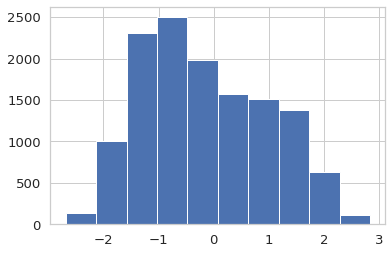

In [ ]:
# Распределение коэффициента улыбки
attrs['Smiling'].hist()

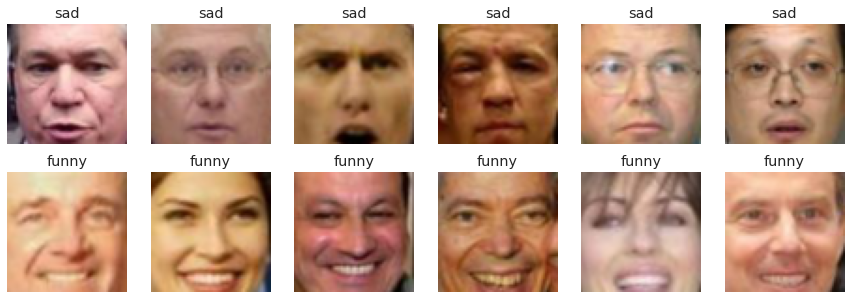

In [ ]:
# Выберем по 50 изображений грустных и улыбающихся людей в датасете
sad_im = data[attrs[attrs['Smiling'] < -1.8].sample(50).index.to_list()]
fun_im = data[attrs[attrs['Smiling'] > 1.8].sample(50).index.to_list()]

# Посмотрим на них
plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(sad_im[i])
    plt.title('sad')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(fun_im[i])
    plt.title('funny')

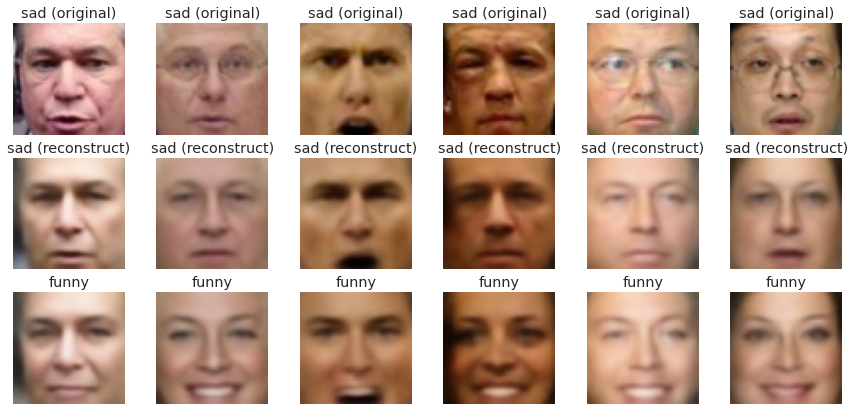

In [ ]:
# Получим латентные вектора улыбающихся и неулыбающихся людей, прогнав
# соответствующие изображения через энкодер
with torch.no_grad():
    latent_sad = autoencoder.encoder(
        torch.tensor(np.rollaxis(sad_im, 3, 1)).to(DEVICE)).cpu()
    latent_fun = autoencoder.encoder(
        torch.tensor(np.rollaxis(fun_im, 3, 1)).to(DEVICE)).cpu()

# Средние латентные векторы улыбающихся и неулыбающихся людей
latent_sad_vector = latent_sad.mean(0)
latent_fun_vector = latent_fun.mean(0)

# Вектор улыбки
smile_vector = latent_fun_vector - latent_sad_vector

# Добавим вектор улыбки к неулыбающимся людям
latent_sad_to_fun = latent_sad + smile_vector

# Восстановим изображения, прогнав получившиеся вектора через декодер
with torch.no_grad():
    sad_to_fun = autoencoder.decoder(
        latent_sad_to_fun.to(DEVICE)).cpu().numpy()
    sad_reconstr = autoencoder.decoder(latent_sad.to(DEVICE)).cpu().numpy()

# Изобразим полученный результат
plt.figure(figsize=(15, 7))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(sad_im[i])
    plt.title('sad (original)')

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(sad_reconstr[i], 0, 3))
    plt.title('sad (reconstruct)')

    plt.subplot(3, 6, i+13)
    plt.axis("off")
    plt.imshow(np.rollaxis(sad_to_fun[i], 0, 3))
    plt.title('funny')

plt.show()

In [ ]:
def change_pic(model, photo, latent_vector, num_itter=5):
    """Показать, как "постепенно" меняется изображение при добавлении к нему
    вектора из латентного пространства"""

    # Преобразуем входное изображение
    tensor_photo = np.expand_dims(np.rollaxis(photo, 2, 0), axis=0)

    # Переводим картинку в латентное пространство
    latent_photo = model.encoder(torch.tensor(tensor_photo).to(DEVICE)).cpu()

    # Добавляем латентный вектор к изображению в латентном пространстве
    new_latent_photo = latent_photo + latent_vector

    # Далее мы будем линейно переводить исходный вектор изображения в вектор
    # измененного изображения.
    # Для этого введем величину alpha - шаг такого перехода.
    alpha = 1. / num_itter

    # Получим список изображений, на которых меняется лицо
    recontstruct = [tensor_photo]
    with torch.no_grad():
        for i in range(num_itter + 1):
            vector = (1 - i * alpha) * latent_photo + \
                i * alpha * new_latent_photo
            recontstruct.append(model.decoder(vector.to(DEVICE)).cpu().numpy())

    # Визуализируем результат
    plt.figure(figsize=(18, 6))
    for i in range(num_itter + 2):
        plt.subplot(1, num_itter + 2, i + 1)
        plt.axis("off")
        plt.imshow(np.rollaxis(recontstruct[i].squeeze(), 0, 3))
        if i:
            plt.title(i-1)
        else:
            plt.title('original')

Протестируем нашу функцию

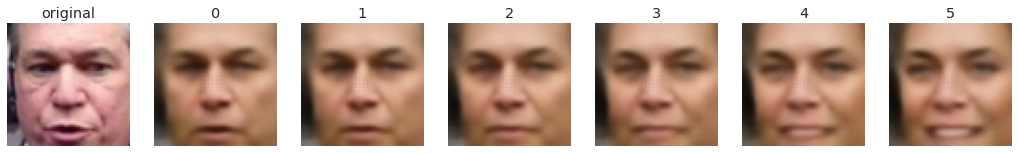

In [ ]:
change_pic(autoencoder, sad_im[0], smile_vector)

Аналогично, домножив "вектор улыбки" на $-1$, т.е. инвертируя его, мы можем получить "вектор грусти"

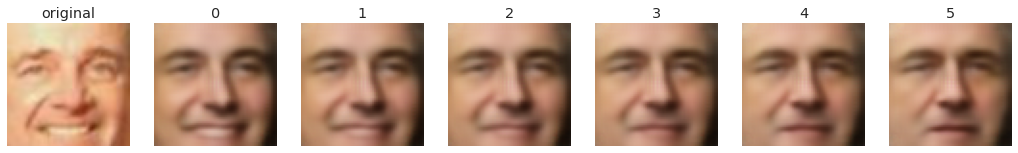

In [ ]:
change_pic(autoencoder, fun_im[0], -smile_vector)

<a id='gender'></a>
## 💃🕺
Мы можем пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем все, на что хватит фантазии и на что есть атрибуты в `attrs`.

Например, повторим то же самое для Male

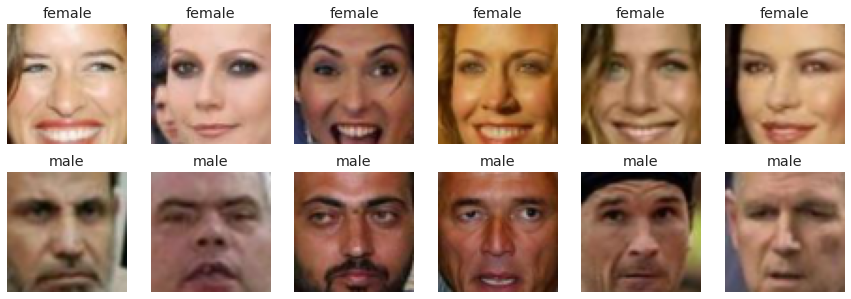

In [ ]:
# Выберем по 500 изображений мужчин и  женщин в датасете
female_im = data[attrs[attrs['Male'] < -1].sample(500).index.to_list()]
male_im = data[attrs[attrs['Male'] > 1].sample(500).index.to_list()]

# Посмотрим на них
plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(female_im[i])
    plt.title('female')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(male_im[i])
    plt.title('male')

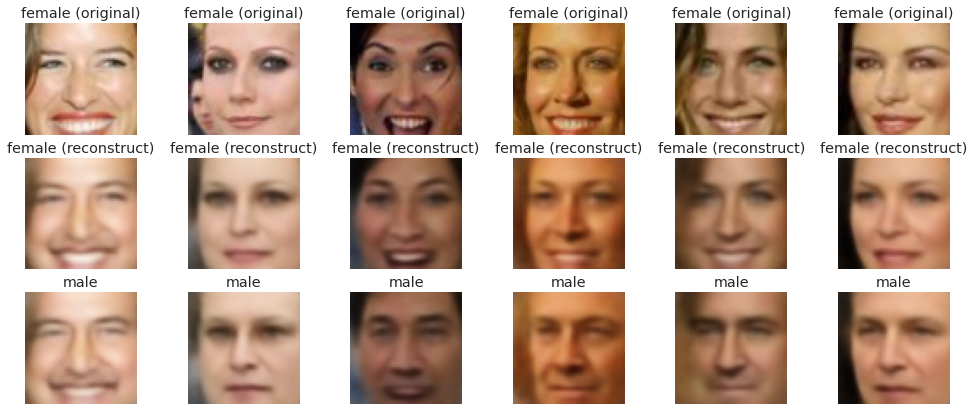

In [ ]:
# Получим латентные вектора женщин и мужчин, прогнав
# соответствующие изображения через энкодер
with torch.no_grad():
    latent_female = autoencoder.encoder(
        torch.from_numpy(np.rollaxis(female_im, 3, 1)).to(DEVICE)).cpu()
    latent_male = autoencoder.encoder(
        torch.from_numpy(np.rollaxis(male_im, 3, 1)).to(DEVICE)).cpu()

# Средние латентные векторы женщин и мужчин
latent_female_vector = latent_female.mean(0)
latent_male_vector = latent_male.mean(0)

# Вектор "пол человека"
gender_vector = latent_male_vector - latent_female_vector

# Добавим gender_vector к изображениям женщин в латентном пространстве
latent_female_to_male = latent_female + gender_vector

# Восстановим изображения, прогнав получившиеся вектора через декодер
with torch.no_grad():
    male = autoencoder.decoder(latent_female_to_male.to(DEVICE)).cpu().numpy()
    female = autoencoder.decoder(latent_female.to(DEVICE)).cpu().numpy()

# Изобразим полученный результат
plt.figure(figsize=(17, 7))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(female_im[i])
    plt.title('female (original)')

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(female[i], 0, 3))
    plt.title('female (reconstruct)')

    plt.subplot(3, 6, i+13)
    plt.axis("off")
    plt.imshow(np.rollaxis(male[i], 0, 3))
    plt.title('male')

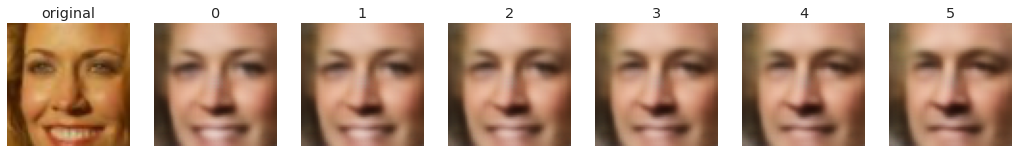

In [ ]:
change_pic(autoencoder, female_im[3], gender_vector)

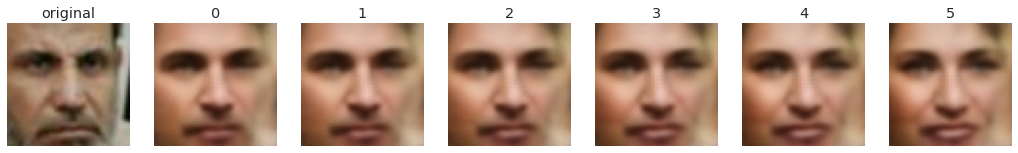

In [ ]:
change_pic(autoencoder, male_im[0], -gender_vector)

Можем также комбинировать вектора. Например, давайте из серьезного мужчины получим весёлую женщину 😀

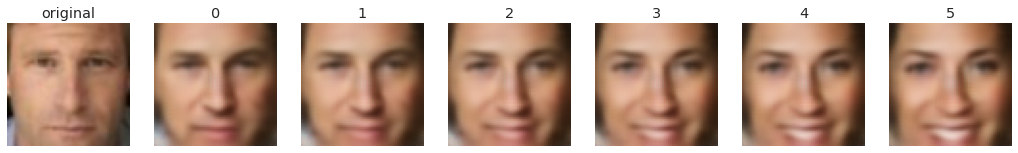

In [ ]:
change_pic(autoencoder, data[0], smile_vector - gender_vector)

<a id='good_or_bad'></a>
# Что такое хорошо и что такое плохо?

<a id='vgg16'></a>
## VGG-16
В этой части мы в качестве энкод- и декод- частей автоэнкодера будем использовать достаточно глубокую сеть -- VGG-16 с батч-нормализацией.

* Simonyan K., Zisserman A. (2014). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/abs/1409.1556)

In [ ]:
dim_code = 128  # размерность латентного пространства


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # Feature Extractor
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Bottleneck
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Flatten(),


            # FC
            nn.Linear(in_features=512*4*4, out_features=512*4),
            nn.ReLU(),
            nn.Linear(in_features=512*4, out_features=dim_code)
        )

        self.decoder = nn.Sequential(
            # FC
            nn.Linear(in_features=dim_code, out_features=512*4),
            nn.ReLU(),
            nn.Linear(in_features=512*4, out_features=512*4*4),
            nn.ReLU(),

            nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),


            # Bottleneck
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),


            # Feature Extractor
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        forward проход автоэнкодера
            latent_code - латентное представление картинки
            reconstruction - полученная реконструкция изображения
        """
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

Определим функцию потерь, модель, оптимизатор и шедулер

In [ ]:
criterion = F.mse_loss

autoencoder = Autoencoder().to(DEVICE)

optimizer = optim.AdamW(params=autoencoder.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
torchsummary.summary(autoencoder, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

Видим, что у такой модели примерно в 5 раз больше обучаемых параметров и примерно в 2 раза больше слоев, то есть модель гораздо глубже. Посмотрим на то, как такие изменения в архитектуре повлияют на результат работы автоэнкодера

epoch: 100%|██████████| 50/50 [1:56:19<00:00, 138.42s/it]


Epoch 050  train_loss: 0.0115      val_loss 0.0117


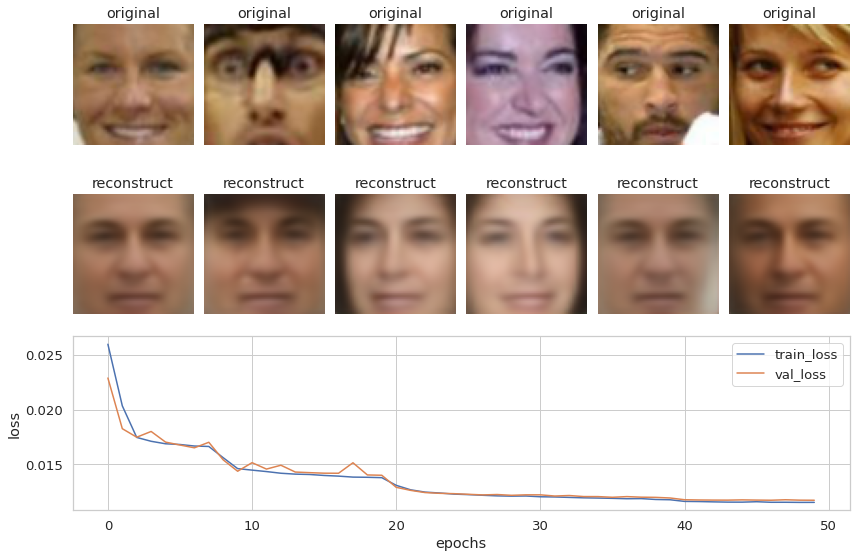

epoch: 100%|██████████| 50/50 [1:56:22<00:00, 139.65s/it]


Training is done! Best epoch 50, best time 6978.355907917023, best val loss 0.011726091336104806, best train loss 0.011532733665692935


In [ ]:
epochs = 50
autoencoder = train_model(train_loader, val_loader, autoencoder,
                          'aevgg', epochs, criterion, optimizer, scheduler)

In [ ]:
# Загрузим обученный автоэнкодер
autoencoder = Autoencoder().to(DEVICE)
autoencoder.load_state_dict(torch.load(
    os.path.join(DATA_DIR, 'best_aevgg.pth')))

<All keys matched successfully>

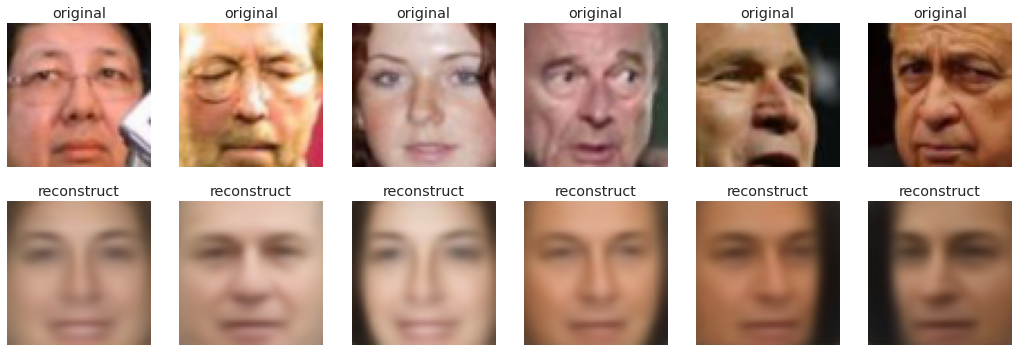

In [ ]:
x_val = next(iter(val_loader))
x_val_np = x_val.detach().numpy()

with torch.no_grad():
    x_reconstr, latent = autoencoder(x_val.to(DEVICE))
    x_reconstr = x_reconstr.cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val_np[i+7], 0, 3))
    plt.title('original')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_reconstr[i+7], 0, 3))
    plt.title('reconstruct')

plt.show()

По графику, отображающему зависимость между функциями потерь и эпохами, видно, что такой автоэнкодер обучается гораздо медленнее. Это вполне ожидаемо, поскольку, как говорилось выше, у такой архитектуры в 5 раз больше обучаемых параметров.

Кроме того, из этого же графика и изображений пропущенных через такую модель, видим, что результат работы такого автоэнкодера заметно хуже. Скорее всего это связано с тем, что сама сеть VGG-16 достаточно глубокая, а в нашем автоэнкодере за счет наличия энкод- и декод- частей эта глубина удваивается. Поэтому градиенты при обучении быстро затухают.

Таким образом, можем сказать, что в качестве основы для автоэнкодеров лучше брать менее глубокие сети или же такие сети, которые способны бороться с затухающими градиентами (например, используя skip connection).

<a id='seg_ae'></a>
## SegAutoencoder

В пункте выше мы увидели, что "простая" глубокая сеть - не лучший вариант для автоэнкодера.  Давайте поможем нашей модели лучше восстанавливать изображения. Для этого воспользуемся идеей, которая была предложена в SegNet'е.

SegNet - нейронная сеть, в основе которой лежит VGG-16 из пункта выше, но в отличие от VGG-16 в ней присутствует "умный" Upsampling. 

Давайте за основу архитектуры для автоэнкодера возьмём SegNet и посмотрим, как такое изменение скажется на качестве работы.


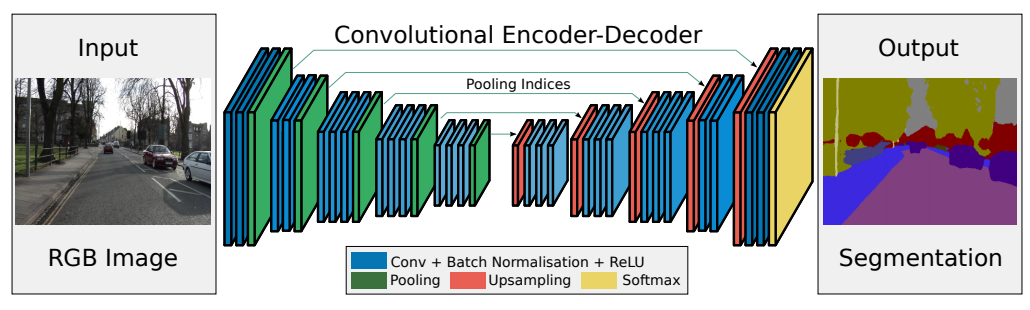

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

На рисунке выше с архитектурой SegNet видно, что в ней есть повторяющиеся `(Conv + BatchNorm + ReLU)` слои, которые выделены синим цветом. Для удобства работы с ними создадим следующую функцую:

In [ ]:
def encod_conv(in_channels, out_channels, deep=1):
    """
    deep - количество (Conv + BatchNorm + ReLU) слоев
    """
    input_layer = (
        nn.Conv2d(in_channels, out_channels,
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    hidden_layer = (
        nn.Conv2d(out_channels, out_channels,
                  kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    # у input и hidden слоев разные input channels
    return nn.Sequential(*(input_layer + (deep - 1) * hidden_layer))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc_conv0 = encod_conv(3, 64, deep=2)
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv1 = encod_conv(64, 128, deep=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv2 = encod_conv(128, 256, deep=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv3 = encod_conv(256, 512, deep=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)

        # Bottleneck
        self.bottleneck_enc_conv = encod_conv(512, 512, deep=3)
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.enc_lin = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512*2*2, out_features=512*2),
            nn.ReLU(),
            nn.Linear(in_features=512*2, out_features=dim_code)
        )

        self.dec_lin = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=512*2),
            nn.ReLU(),
            nn.Linear(in_features=512*2, out_features=512*2*2),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(512, 2, 2))
        )

        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2)
        self.bottleneck_dec_conv = encod_conv(512, 512, deep=3)

        # Decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv0 = encod_conv(512, 256, deep=3)
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv1 = encod_conv(256, 128, deep=3)
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv2 = encod_conv(128, 64, deep=2)
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=(3, 3),
                      stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        forward проход автоэнкодера
            latent_code - латентное представление картинки
            reconstruction - полученная реконструкция изображения
        """

        # Encoder
        e0, e0_idx = self.pool0(self.enc_conv0(x))  # idx = indexes
        e1, e1_idx = self.pool1(self.enc_conv1(e0))
        e2, e2_idx = self.pool2(self.enc_conv2(e1))
        e3, e3_idx = self.pool3(self.enc_conv3(e2))

        # Bottleneck
        b_enc, b_enc_idx = self.bottleneck_pool(self.bottleneck_enc_conv(e3))
        latent_code = self.enc_lin(b_enc)

        l_dec = self.dec_lin(latent_code)
        b_dec = self.bottleneck_dec_conv(
            self.bottleneck_upsample(l_dec, b_enc_idx)
        )

        # Decoder
        d0 = self.dec_conv0(self.upsample0(b_dec, e3_idx))
        d1 = self.dec_conv1(self.upsample1(d0, e2_idx))
        d2 = self.dec_conv2(self.upsample2(d1, e1_idx))
        reconstruction = self.dec_conv3(self.upsample3(d2, e0_idx))

        return reconstruction, latent_code

Интуиция подсказывает, что из-за MaxUnpool'а с пробросом индексов из энкодера в декодер качество такой модели будет гораздо лучше.

In [ ]:
criterion = F.mse_loss

autoencoder = Autoencoder().to(DEVICE)

optimizer = optim.AdamW(params=autoencoder.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

epoch: 100%|██████████| 50/50 [1:47:33<00:00, 129.41s/it]


Epoch 050  train_loss: 0.0012      val_loss 0.0014


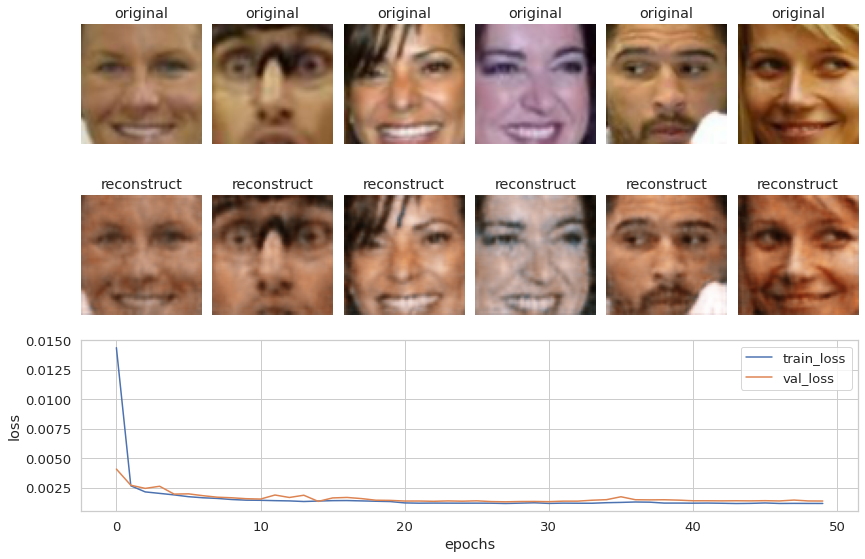

epoch: 100%|██████████| 50/50 [1:47:36<00:00, 129.13s/it]


Training is done! Best epoch 28, best time 3601.8330824375153, best val loss 0.0013319398566882194, best train loss 0.0011906628935520044


In [ ]:
epochs = 50
autoencoder = train_model(train_loader, val_loader, autoencoder,
                          'seg', epochs, criterion, optimizer, scheduler)

In [ ]:
# Загрузим обученный автоэнкодер
autoencoder = Autoencoder().to(DEVICE)
autoencoder.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_seg.pth')))

<All keys matched successfully>

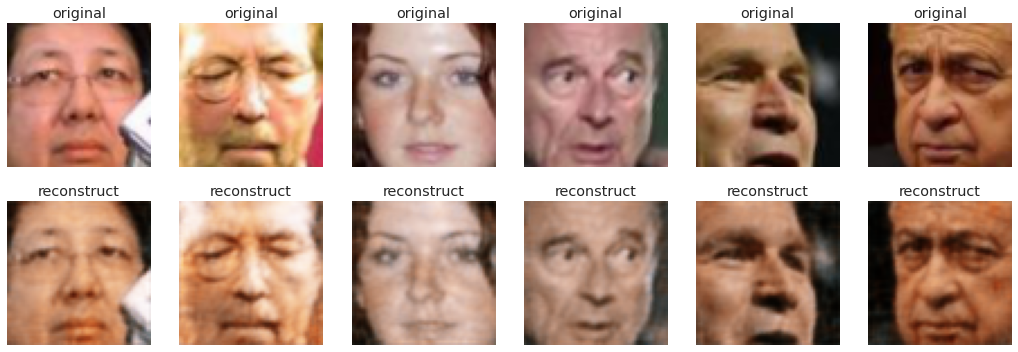

In [ ]:
x_val = next(iter(val_loader))
x_val_np = x_val.detach().numpy()

with torch.no_grad():
    x_reconstr, latent = autoencoder(x_val.to(DEVICE))
    x_reconstr = x_reconstr.cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val_np[i+7], 0, 3))
    plt.title('original')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_reconstr[i+7], 0, 3))
    plt.title('reconstruct')

plt.show()

Видно, что такой автоэнкодер очень хорошо восстанавливает лица. Это видно и по самим изображениям, и по значению функции потерь. 

Кроме того, из графика для лоссов видно, что такая модель гораздо быстрее обучается. 

Такое хорошее качество восстановления изображений обусловленно архитектурой, а именно Unpooling'ом с пробросом.

Важно понимать, что у такого автоэнкодера нельзя "отделить" декодер-часть от энкодера. Потому для большинства практических задач, которые мы обсудим в следующих блокнотах, такая архитектура не применима.